In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
import numpy as np
from scipy.signal import savgol_filter


In [2]:
path = "C:/Users/VR-Lab/Documents/Projects/LH_Project/Data/"
file = "ptxid_33_condition_33_trial_33_time_010324_103342.json"

In [3]:
df = pd.read_json(path+file)
df

,heart_rate,gsr_response,time,phase,Participant_ID,Condition,Trial
0,537,1,0.507334,startNow,33,33,33
1,165,0,0.516296,startNow,33,33,33
2,353,1,0.527262,startNow,33,33,33
3,185,1,0.538337,startNow,33,33,33
4,169,1,0.549203,startNow,33,33,33
...,...,...,...,...,...,...,...
29095,23,0,312.204091,calm_end,33,33,33
29096,380,2,312.206089,calm_end,33,33,33
29097,89,0,312.209077,calm_end,33,33,33
29098,277,2,312.211072,calm_end,33,33,33


## GSR Filtered and phases labelled on plot

<Axes: xlabel='phase', ylabel='gsr_response'>

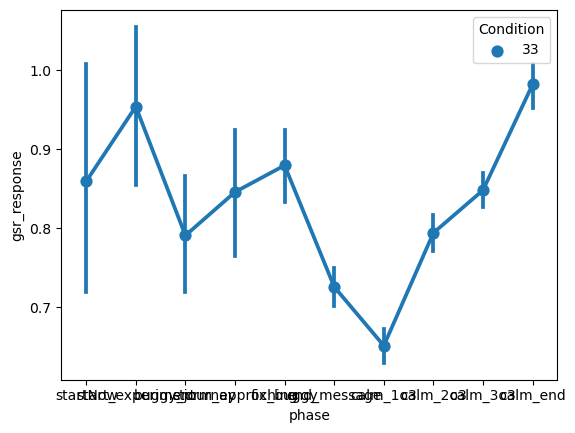

In [18]:
sns.pointplot(x='phase',y='gsr_response', data=df, hue='Condition')

In [11]:
# gsr_segment = df['gsr_response'][100:-1]
# gsr_filtered = savgol_filter(gsr_segment, 1000, 5) # window size 51, polynomial order 3

# plt.plot(gsr_filtered)
# plt.xlabel('Time / time steps over 7 mins')
# plt.ylabel('GSR Response / R')

# plt.text(800,975, 'Baseline')
# plt.text(5800,975, 'Phase_1')
# plt.text(10800,975, 'Phase_2')
# plt.text(15800,975, 'Phase_3')
# plt.text(20500,975, 'Washout')

# plt.plot([5000,5000],[950,980],'k--')
# plt.plot([10000,10000],[950,980],'k--')
# plt.plot([15000,15000],[950,980],'k--')
# plt.plot([20000,20000],[950,980],'k--')

Heart Rate: 2206.5700408368875 BPM


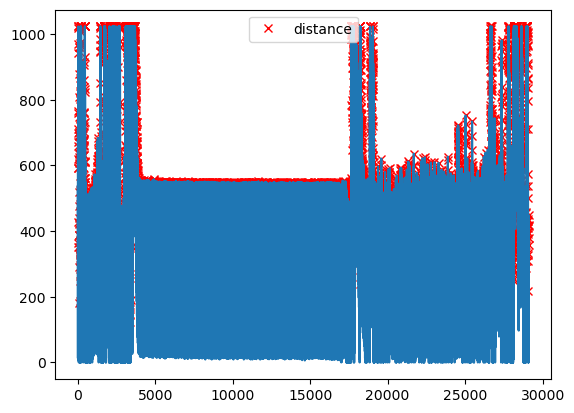

In [5]:
x = df['heart_rate']
peaks, _ = find_peaks(x, prominence=120)
plt.plot(peaks, x[peaks], "xr"); plt.plot(x); plt.legend(['distance'])

time = df['time'].values[-1] 

heart_rate = (len(peaks) / time) * 60

print('Heart Rate: ' + str(heart_rate) + ' BPM')

<Axes: xlabel='phase', ylabel='heart_rate'>

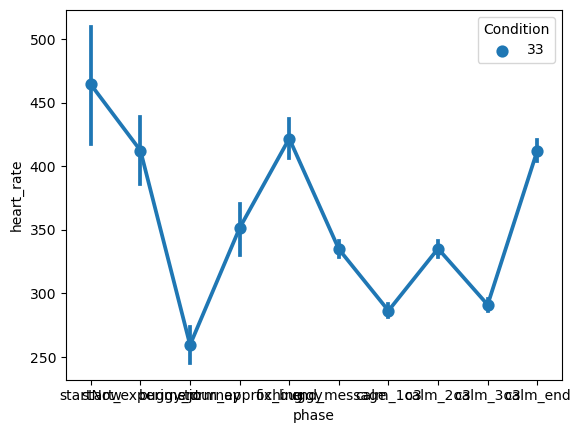

In [16]:
sns.pointplot(x='phase', y='heart_rate', data=df, hue='Condition')

### Compute the Heart Rate Varibility (HRV) 
Use a window of a certain size (experiment with different window sizes) to compute this value

In [10]:
pd.unique(df['phase'])

array(['startNow', 'start_experiment', 'buggy_journey',
       'storm_approching', 'fix_buggy', 'end_message', 'calm_1o3',
       'calm_2o3', 'calm_3o3', 'calm_end'], dtype=object)

In [6]:
time

312.213067

In [7]:
time = df['time'].values[-1] 
numb_per_samples = len(df['time'])

print("Duration: " + str(time))
print("Samples: " + str(numb_per_samples))

sampling_rate = numb_per_samples / time

print('Sampling rate: ' + str(np.round(sampling_rate)))

Duration: 312.213067
Samples: 29100
Sampling rate: 93.0


### Overall heart rate variability (HRV)

#### Dumb way of computing the HRV for the different conditions

In [40]:
print(len(peaks)/5)

baseline_start = peaks[50:177]
condition_1 = peaks[178:177*2]
condition_2 = peaks[2*177:177*3]
condition_3 = peaks[3*177:177*4]
baseline_end = peaks[4*177:177*5]


176.6


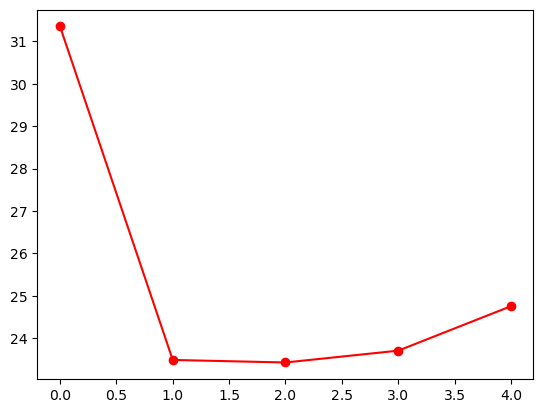

In [41]:
plt.plot([0,1,2,3,4], [np.nanmean(np.diff(baseline_start)), 
                      np.nanmean(np.diff(condition_1)),
                      np.nanmean(np.diff(condition_2)),
                      np.nanmean(np.diff(condition_3)),
                      np.nanmean(np.diff(baseline_end)),], 'r-o')

In [42]:
baseline_start_hr = len(peaks[50:177]) / (peaks[50:177] * (1/sampling_rate) * 60)
condition_1_hr = len(peaks[178:177*2]) / (peaks[178:177*2] * (1/sampling_rate) * 60)
condition_2_hr = len(peaks[2*177:177*3]) / (peaks[2*177:177*3] * (1/sampling_rate) * 60)
condition_3_hr = len(peaks[3*177:177*4] ) / (peaks[3*177:177*4] * (1/sampling_rate) * 60)
baseline_end_hr = len(peaks[4*177:177*5]) / (peaks[4*177:177*5] * (1/sampling_rate) * 60)

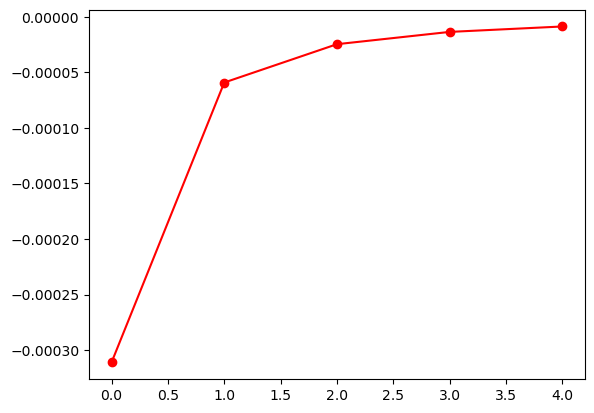

In [43]:
plt.plot([0,1,2,3,4], [np.nanmean(np.diff(baseline_start_hr)), 
                      np.nanmean(np.diff(condition_1_hr)),
                      np.nanmean(np.diff(condition_2_hr)),
                      np.nanmean(np.diff(condition_3_hr)),
                      np.nanmean(np.diff(baseline_end_hr)),], 'r-o')

In [19]:
hr_time_diff = np.diff(peaks)
hr_variability = np.std(hr_time_diff)

print('Average HRV: ' + str(np.round(np.mean(hr_time_diff * (1/sampling_rate)),3)) + ' SD: ' + str(np.round(hr_variability * (1/sampling_rate),3)))

Average HRV: 0.509 SD: 0.441


In [ ]:
df['HRV'] = hr_time_diff


### HRV Per condition 

In [ ]:


hr_time_diff = np.diff(peaks)
hr_variability = np.std(hr_time_diff)

print('Average HRV: ' + str(np.round(np.mean(hr_time_diff * (1/sampling_rate)),3)) + ' SD: ' + str(np.round(hr_variability * (1/sampling_rate),3)))